In [1]:
# Check NVIDIA System Management Interface (NVIDIA-SMI) to monitor GPU
!nvidia-smi

Mon May 27 11:37:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
# Get the current working directory
HOME = os.getcwd()
print(HOME)

/content


In [3]:
# Install the required Python packages
!pip install -q ultralytics supervision==0.18.0
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.8 MB/s eta 0:00:00


## Imports

In [4]:
import numpy as np
import supervision as sv
import gdown

from ultralytics import YOLO
from supervision.assets import download_assets, VideoAssets

## Download video

In [5]:
# Download the test video from Google Drive
file_id = '19vB1vbt9jhuwJcuRh87X9rkmDIXgLU_u'
output = 'Vehicle-Counting_test.mp4'

gdown.download(f'https://drive.google.com/uc?id=19vB1vbt9jhuwJcuRh87X9rkmDIXgLU_u', output, quiet=False)

# Set the source video path
SOURCE_VIDEO_PATH = output

Downloading...
From: https://drive.google.com/uc?id=19vB1vbt9jhuwJcuRh87X9rkmDIXgLU_u
To: /content/Vehicle-Counting_test.mp4
100%|██████████| 29.2M/29.2M [00:00<00:00, 49.0MB/s]


## Read single frame from video

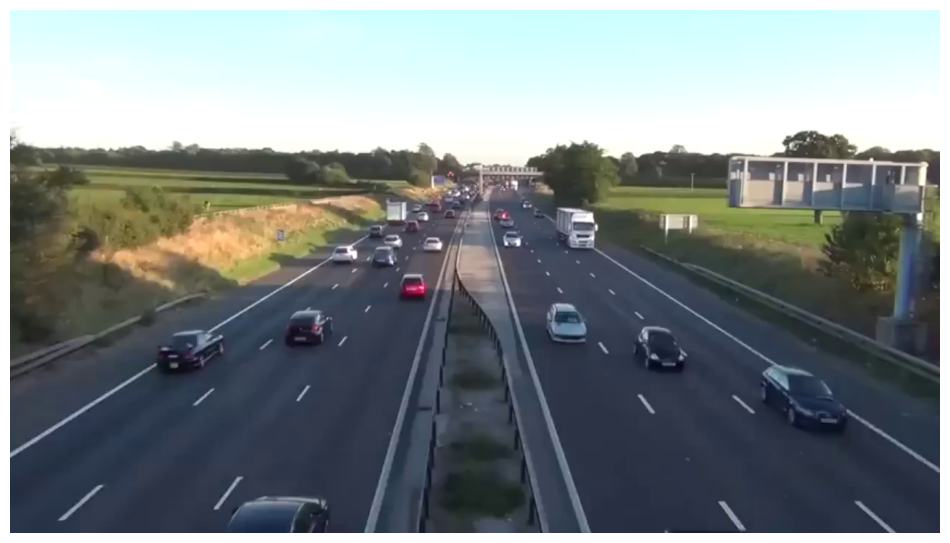

In [6]:
# Generate video frames and display the first frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (12, 12))

In [7]:
# Get video information
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=1503)

In [8]:
# Load YOLO model and perform object detection on the first frame
model = YOLO("yolov8x.pt")

results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

100%|██████████| 131M/131M [00:00<00:00, 167MB/s]


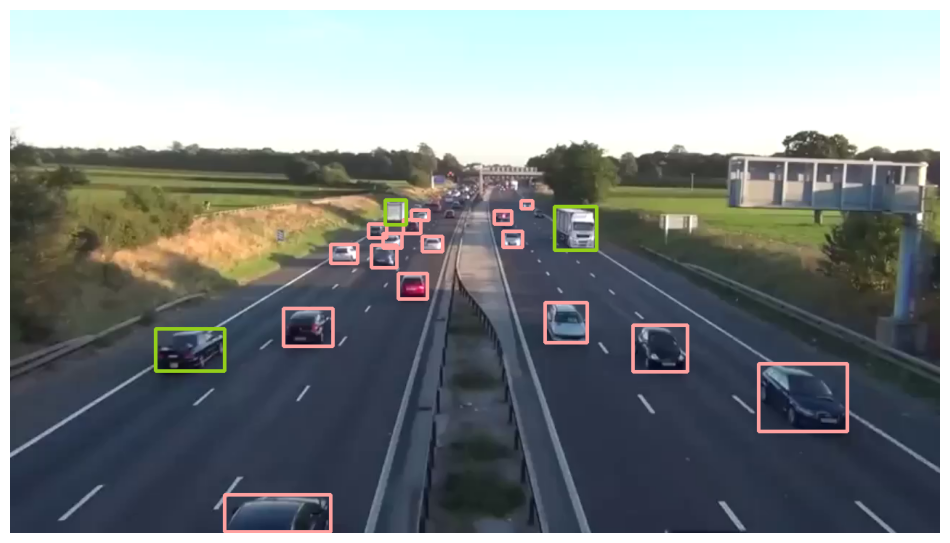

In [9]:
# Annotate the detected bounding boxes on the frame and display it
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=4)
annotated_frame = bounding_box_annotator.annotate(frame.copy(), detections)
sv.plot_image(annotated_frame, (12, 12))

## Improve Vizualizations

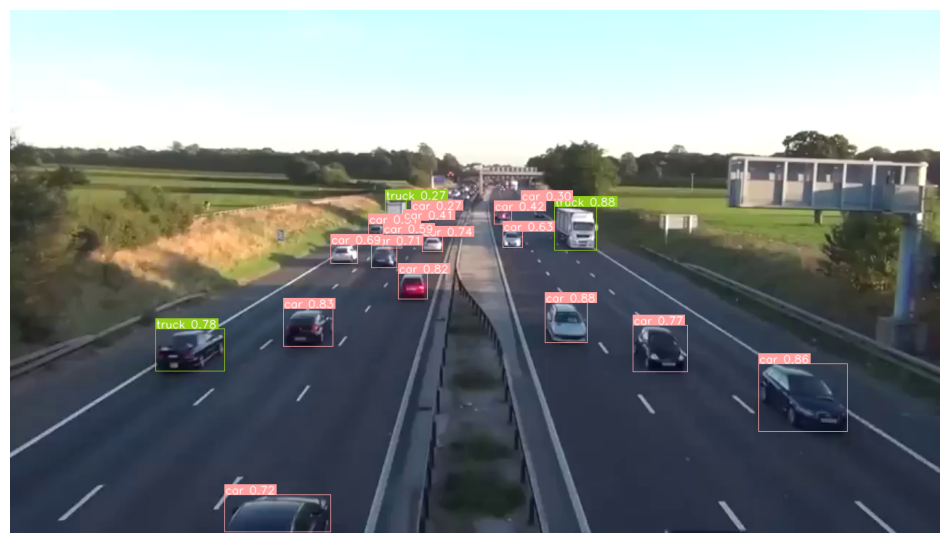

In [10]:
# Annotate bounding boxes and labels on the frame and display it
labels = [
    f"{results.names[class_id]} {confidence:0.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=1)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_padding=1)

annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame, (12, 12))

## Define Line Position

In [11]:
# Get video information again
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=1503)

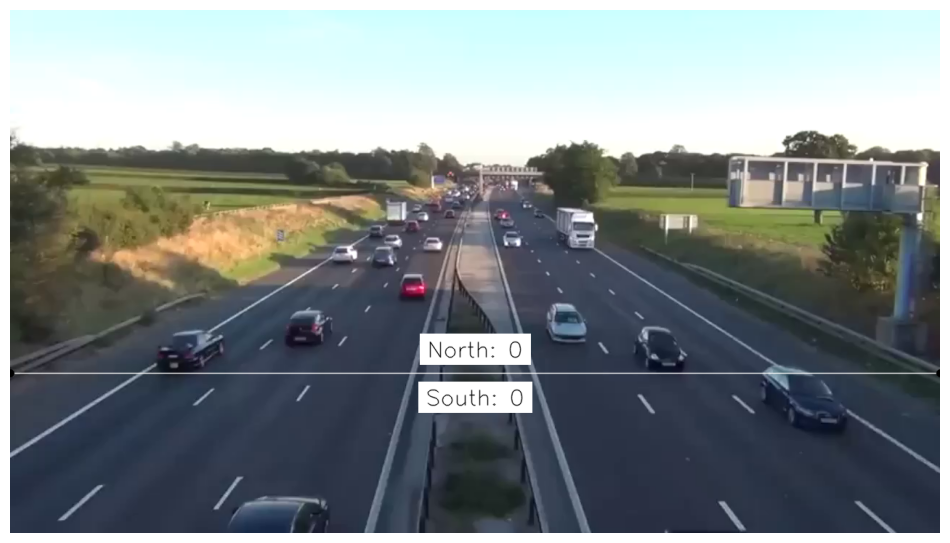

In [12]:
# Define a line zone for vehicle counting and display it
START = sv.Point(0, 500)
END = sv.Point(1280, 500)

line_zone = sv.LineZone(start=START, end=END)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=1,
    text_thickness=1,
    text_scale=1,
    custom_in_text="North",
    custom_out_text="South"
)

annotated_frame = frame.copy()
annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)
sv.plot_image(annotated_frame, (12, 12))

## Process Video

In [13]:
# Initialize ByteTrack for object tracking
byte_tracker = sv.ByteTrack()

In [14]:
# Initialize annotators for bounding boxes, labels, and traces
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=1)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.5, text_padding=1)
trace_annotator = sv.TraceAnnotator(thickness=4)

In [15]:
# Define a callback function to process each frame
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = byte_tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )
    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections
    )
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels
    )

    line_zone.trigger(detections)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

In [16]:
# Define the target video path for the processed video
TARGET_VIDEO_PATH = f"{HOME}/Result.mp4"

In [17]:
# Process the video with the callback function and save the result
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)